<a href="https://colab.research.google.com/github/mkalmano/QBNFL_Elo/blob/main/NFL_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NFL Player Analytics**
### Braden desGarennes & Maksim Kalmanovich
### February 2023

**Reasoning:** A very common held "fact" seen around Football and Twitter is that the QB is a football team's most important factor which leads to the most wins. This can be seen, not only if you ask a fan, coach, or player but is clearly represented in the NFL's MVPs going to QBs 46/67 times (69%) and Super Bowl MVPS going to QBs 32/57 times (56.1%) even though it makes up 1/20 positions (5%) on a football team. We wanted to test this theory and see if the data actually backs this up or if this common held belief is in fact innacurate. We looked at all games, from 1950 to 2021 and used Elo which is a system that judges teams and players based on past results.    

[Is QB The Most Important Position In All Of Sports?](https://bleacherreport.com/articles/55776-nfl-analysis-is-qb-the-most-important-position-in-all-of-sports)

[Why is QB considered that important of a position?](https://www.reddit.com/r/NFLNoobs/comments/gf5d9b/why_is_qb_considered_that_important_of_a_position/)

More on [ELO](https://fivethirtyeight.com/methodology/how-our-nfl-predictions-work/). 

**Hypothesis:** Quarterbacks have the most impact on wins on the football field.

## **Data import & cleaning**

In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas
import numpy as np

In [ ]:
import pandas as pd

# load in NFL elo data
url="https://projects.fivethirtyeight.com/nfl-api/nfl_elo.csv"
elo_df = pd.read_csv(url)

# remove old rows
elo_df = elo_df.drop(index=range(2162))

# remove unnecessary columns
elo_df = elo_df.drop(columns=['neutral', 'importance', 'total_rating', "score1","score2"])

# make dummy var for playoff
def replace_na_with_0(val):
    if pd.isna(val):
        return 0
    else:
        return 1

elo_df['playoff'] = elo_df['playoff'].apply(replace_na_with_0)

# print first few rows of the dataframe
elo_df.head()


,date,season,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,...,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,quality
2162,1950-09-16,1950,0,PHI,CLE,1674.314,1647.304,0.629402,0.370598,1631.511,...,0.0,0.620653,0.379347,-123.09,275.22,-12.309,27.522,1630.613026,1685.827280,98.0
2163,1950-09-17,1950,0,BCL,WSH,1337.541,1454.448,0.425851,0.574149,1310.758,...,0.0,0.425357,0.574643,3.63,251.79,0.363,25.179,1310.867671,1481.487455,6.0
2164,1950-09-17,1950,0,PIT,NYG,1485.849,1461.717,0.625529,0.374471,1453.448,...,0.0,0.612587,0.387413,-34.98,-54.12,-3.498,-5.412,1454.118729,1493.988602,35.0
2165,1950-09-17,1950,0,GB,DET,1353.646,1449.128,0.456245,0.543755,1320.673,...,0.0,0.443900,0.556100,-37.62,115.17,-3.762,11.517,1322.441687,1481.661757,7.0
2166,1950-09-17,1950,0,LAR,CHI,1564.606,1628.688,0.501321,0.498679,1548.463,...,0.0,0.498518,0.501482,-12.21,-30.03,-1.221,-3.003,1549.226817,1643.798965,88.0


In [ ]:
url = "https://raw.githubusercontent.com/fivethirtyeight/nfl-elo-game/master/data/nfl_games.csv"
results_df = pd.read_csv(url)

# remove unnecessary columns
results_df = results_df.drop(columns=['elo1', 'elo2', 'elo_prob1','neutral', "playoff"])

results_df.head()

,date,season,team1,team2,score1,score2,result1
0,1920-09-26,1920,RII,STP,48,0,1.0
1,1920-10-03,1920,AKR,WHE,43,0,1.0
2,1920-10-03,1920,RCH,ABU,10,0,1.0
3,1920-10-03,1920,DAY,COL,14,0,1.0
4,1920-10-03,1920,RII,MUN,45,0,1.0


In [ ]:
merged_df = pd.merge(elo_df, results_df, on=["date", "team1", "team2", "season"])
merged_df.describe()

,season,playoff,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,...,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,quality,score1,score2,result1
count,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,...,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000,14648.000000
mean,1990.862780,0.038435,1504.676541,1502.907499,0.582791,0.417209,1504.324673,1503.259369,1504.129467,1502.829102,...,107.854961,87.253721,96.086827,94.014281,1504.174053,1502.784516,47.980543,22.509353,19.829328,0.573833
std,18.630119,0.192251,103.283439,101.911263,0.172918,0.172918,105.761879,103.959681,100.158164,98.902529,...,133.298020,131.595488,57.771029,57.171035,102.627943,101.132417,29.356534,10.726332,10.286373,0.492027
min,1950.000000,0.000000,1153.902000,1156.551000,0.070953,0.029484,1166.933000,1153.902000,1149.699743,1152.474651,...,-385.737110,-413.971659,-46.329533,-53.778917,1164.327676,1149.699743,0.000000,0.000000,0.000000,0.000000
25%,1976.000000,0.000000,1432.083500,1432.194500,0.460660,0.285708,1430.130750,1430.436000,1433.940308,1434.312130,...,14.717080,-6.171507,53.929676,52.351545,1432.405966,1431.987497,22.000000,14.000000,13.000000,0.000000
50%,1993.000000,0.000000,1505.078500,1504.262500,0.593721,0.406279,1504.721500,1504.848500,1505.720834,1504.449776,...,104.899185,82.777687,90.507947,88.758575,1505.163207,1505.105619,48.000000,22.000000,20.000000,1.000000
75%,2007.000000,0.000000,1578.082500,1576.941500,0.714292,0.539340,1580.522750,1578.268250,1574.571897,1574.782379,...,198.561090,175.672226,131.832023,129.936851,1578.430253,1575.017243,73.000000,30.000000,27.000000,1.000000
max,2020.000000,1.000000,1839.663000,1849.484000,0.970516,0.929047,1849.484000,1831.462000,1806.390160,1814.366226,...,713.695222,605.098179,327.716545,329.562716,1814.366226,1806.223590,100.000000,72.000000,62.000000,1.000000


In [ ]:
merged_df['result2'] = np.where(merged_df['result1'] == 0.0, 1.0, 0.0)

merged_df['result1'] = np.where(merged_df['result1'] == 0.0, 'Loss', 'Win')

merged_df['result2'] = np.where(merged_df['result2'] == 0.0, 'Loss', 'Win')

merged_df

,date,season,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,quality,score1,score2,result1,result2
0,1950-09-16,1950,0,PHI,CLE,1674.314000,1647.304000,0.629402,0.370598,1631.511000,...,275.220000,-12.309000,27.522000,1630.613026,1685.827280,98.0,10,35,Loss,Win
1,1950-09-17,1950,0,BCL,WSH,1337.541000,1454.448000,0.425851,0.574149,1310.758000,...,251.790000,0.363000,25.179000,1310.867671,1481.487455,6.0,14,38,Loss,Win
2,1950-09-17,1950,0,PIT,NYG,1485.849000,1461.717000,0.625529,0.374471,1453.448000,...,-54.120000,-3.498000,-5.412000,1454.118729,1493.988602,35.0,7,18,Loss,Win
3,1950-09-17,1950,0,GB,DET,1353.646000,1449.128000,0.456245,0.543755,1320.673000,...,115.170000,-3.762000,11.517000,1322.441687,1481.661757,7.0,7,45,Loss,Win
4,1950-09-17,1950,0,LAR,CHI,1564.606000,1628.688000,0.501321,0.498679,1548.463000,...,-30.030000,-1.221000,-3.003000,1549.226817,1643.798965,88.0,20,24,Loss,Win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14643,2021-01-17,2020,1,KC,CLE,1712.652090,1552.012725,0.785647,0.214353,1719.618921,...,107.241204,271.760879,175.170110,1718.032247,1562.129125,98.0,22,17,Win,Loss
14644,2021-01-17,2020,1,NO,TB,1704.051294,1645.074008,0.671212,0.328788,1669.939047,...,221.469763,198.244018,221.747091,1700.946212,1660.789489,100.0,20,30,Loss,Win
14645,2021-01-24,2020,1,GB,TB,1715.623187,1679.186255,0.641968,0.358032,1691.506146,...,121.078453,268.837927,211.680227,1665.877222,1684.319058,100.0,26,31,Loss,Win
14646,2021-01-24,2020,1,KC,BUF,1719.618921,1719.974149,0.591972,0.408028,1741.087279,...,241.765435,282.261326,270.137585,1742.902172,1681.289840,100.0,38,24,Win,Loss


##**Definitions:**

*elo1_pre*:	Home team's Elo rating before the game

*elo2_pre*:	Away team's Elo rating before the game

*qbelo1_pre*:	Home team's quarterback-adjusted base rating before the game

*qbelo2_pre*: Away team's quarterback-adjusted base rating before the game

*qb1_value_pre*:	Home starting quarterbacks's raw Elo value before the game

*qb2_value_pre*:	Away starting quarterbacks's raw Elo value before the game


The formula for QB VALUE is: -2.2 * Pass Attempts + 3.7 * Completions + (Passing Yards / 5) + 11.3 * Passing TDs – 14.1 * Interceptions – 8 * Times Sacked – 1.1 * Rush Attempts + 0.6 * Rushing Yards + 15.9 * Rushing TDs

[source1](https://fivethirtyeight.com/methodology/how-our-nfl-predictions-work/)
[source2](https://github.com/fivethirtyeight/data/tree/master/nfl-elo)

In our anlysis we explored the date from a home team perspective in order to better standardize our results, as home teams have a noticable advantage.

## **Boxplot: Team ratings**

In [ ]:
#ratio of elo1/elo2 value prior to game
merged_df['team_elo'] = (merged_df['elo1_pre'])/merged_df['elo2_pre']

#ratio of qb adj elo1 value prior to game
merged_df['qbadj_elo'] = (merged_df['qbelo1_pre'])/merged_df['qbelo2_pre']


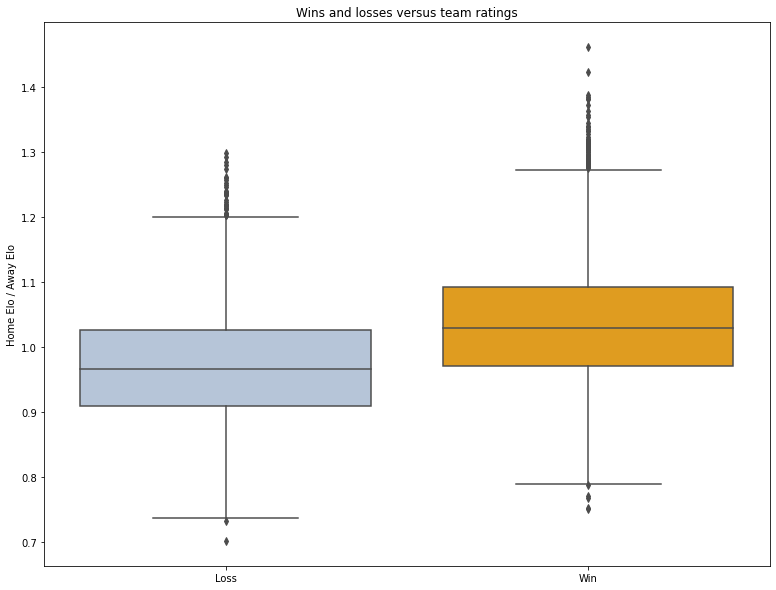

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(13, 10))

colors = {"Win":"orange","Loss":"lightsteelblue"}

ax = sns.boxplot(x='result1', y='team_elo', data=merged_df, ax=ax,palette=colors)

median = merged_df.groupby("result1")["team_elo"].median()

# Set x and y axis labels
ax.set_xlabel('')  
ax.set_ylabel('Home Elo / Away Elo')

# Set plot title
ax.set_title('Wins and losses versus team ratings')

# show the graph

plt.show()

As expected when home teams win, they typically have a higher rating going into the game.

# **Boxplot: QB adj. team ratings**

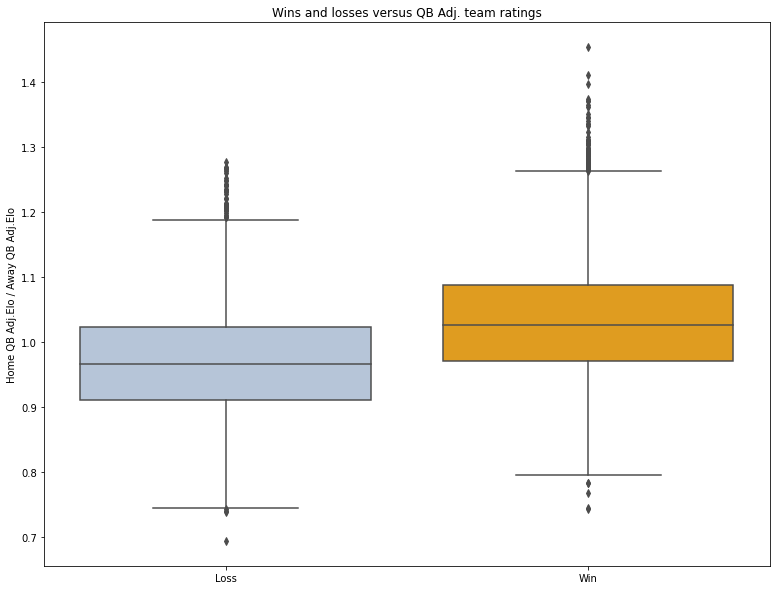

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(13, 10))

colors = {"Win":"orange","Loss":"lightsteelblue"}

ax = sns.boxplot(x='result1', y='qbadj_elo', data=merged_df, ax=ax,palette=colors)

median = merged_df.groupby("result1")["qbadj_elo"].median()

# Set x and y axis labels
ax.set_xlabel('')  
ax.set_ylabel('Home QB Adj.Elo / Away QB Adj.Elo')

# Set plot title
ax.set_title('Wins and losses versus QB Adj. team ratings')

# show the graph

plt.show()

We used the adjusted Elo that controls for the rating of a teams QB. Compared to the prior boxplot we can see that there is almost no visible change, meaning that a QB's impact on wins is not very noticable when looking at the team as a whole. 

## **Boxplot: Score differential**

In [ ]:
# create new variable based on qb1 > qb2
merged_df['qb1_better'] = merged_df.apply(lambda row: "Better QB" if row['qb1_value_pre'] > row['qb2_value_pre'] else "Worse QB", axis=1)
merged_df['score_diff'] = (merged_df['score1'])-(merged_df['score2'])

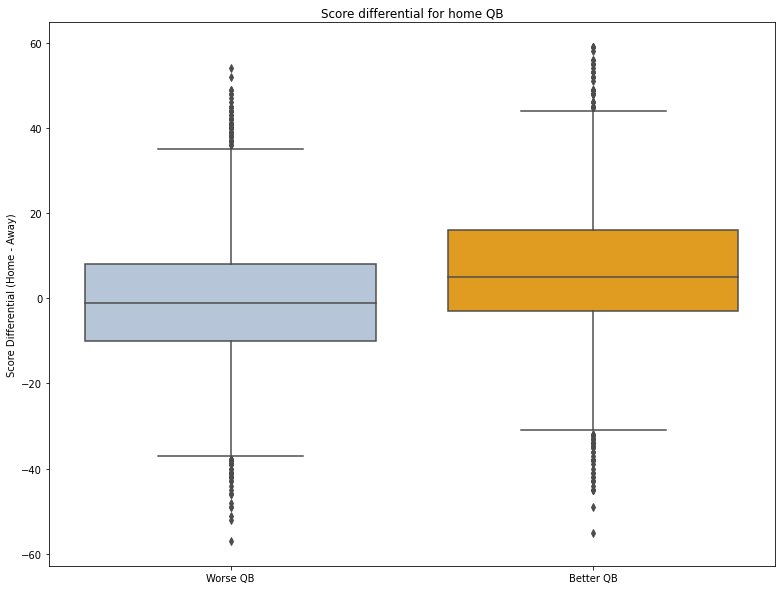

In [ ]:
fig, ax = plt.subplots(figsize=(13, 10))

colors= {"Better QB":"orange","Worse QB":"lightsteelblue"}

ax = sns.boxplot(x='qb1_better', y='score_diff', data=merged_df, ax=ax,palette=colors)

# Set x and y axis labels
ax.set_xlabel('')  
ax.set_ylabel('Score Differential (Home - Away)')

# Set plot title
ax.set_title('Score differential for home QB')

plt.show()

This graph compares the home team QB rating to the away team QB rating. The negative score differencial indicate a team is expected to lose while positive one means it is expected to win. As can be seen in the "Better QB" boxplot, when the home team has a better QB they typically have a positive scoring differential. When the home team has a worse QB the median scoring differential is slightly below zero, meaning they are projected to lose, even at home (althought the median is within a one score difference).

## **Top and Bottom 10 Home QB Ratings (by week)**

In [ ]:
#QB 
df_descending = merged_df.sort_values("qb1_value_pre", ascending=False)

desc= df_descending[["qb1","team1", "team2","date", "season", "qb1_value_pre","result1"]]

# bottom 10 
print(desc.head(10))

                   qb1 team1 team2        date  season  qb1_value_pre result1
12244       Drew Brees    NO   WSH  2012-09-09    2012     329.562716    Loss
12232       Drew Brees    NO   DET  2012-01-07    2011     317.472758     Win
14567  Patrick Mahomes    KC   DEN  2020-12-06    2020     313.828383     Win
12588   Peyton Manning   DEN   JAX  2013-10-13    2013     308.762381     Win
14008       Drew Brees    NO   ATL  2018-11-22    2018     306.844132     Win
12215       Drew Brees    NO   ATL  2011-12-26    2011     305.254462     Win
14373    Lamar Jackson   BAL   TEN  2020-01-11    2019     303.406651    Loss
12776   Peyton Manning   DEN   SEA  2014-02-02    2013     302.858233    Loss
12773   Peyton Manning   DEN   LAC  2014-01-12    2013     300.117048     Win
12220       Drew Brees    NO   CAR  2012-01-01    2011     299.713380     Win


Seven out of ten of the teams with these QBs won that week.

All of the top QB's are notibly famous and pro bowl / hall of fame level QB's. However, in these years not a single one of them won a superbowl.

In [ ]:
#QB
df_ascending = merged_df.sort_values("qb1_value_pre")

asc = df_ascending[["qb1","team1", "team2","date", "season", "qb1_value_pre","result1"]]

# top 10 
print(asc.head(10))

                qb1 team1 team2        date  season  qb1_value_pre result1
5304  Paul McDonald   CLE    NE  1984-10-07    1984     -53.778917    Loss
3596  Kim McQuilken   ATL   CLE  1976-10-17    1976     -46.720908    Loss
2350    Rick Norton   MIA   DEN  1969-12-07    1969     -46.329533     Win
6298   Rusty Hilger   DET    TB  1988-11-13    1988     -44.985444    Loss
3630  Kim McQuilken   ATL    NO  1976-10-31    1976     -44.032286     Win
65       Tobin Rote    GB    SF  1950-11-26    1950     -42.063714     Win
2343    Rick Norton   MIA    NE  1969-11-30    1969     -39.881058    Loss
5325  Paul McDonald   CLE   NYJ  1984-10-14    1984     -39.036961    Loss
6333   Rusty Hilger   DET    GB  1988-12-04    1988     -38.106327     Win
5276  Paul McDonald   CLE   PIT  1984-09-23    1984     -35.867069     Win


Five out of ten of the teams with these QBs won that week.

As expected teams with QBs that are a negative outlier have not made the superbowl during these years. These Qbs are not noteworthy.

## **Top and Bottom 10 Home Team Ratings (by week)**

In [ ]:
#Team
df_descending = merged_df.sort_values("elo1_pre", ascending=False)

desc= df_descending[["team1", "team2","date", "season", "elo1_pre","result1"]]

# bottom 10 
print(desc.head(10))

      team1 team2        date  season  elo1_pre result1
11173    NE   LAC  2008-01-20    2007  1839.663     Win
11168    NE   JAX  2008-01-12    2007  1831.462     Win
11136    NE   MIA  2007-12-23    2007  1824.224     Win
11118    NE   NYJ  2007-12-16    2007  1821.815     Win
11105    NE   PIT  2007-12-09    2007  1810.502     Win
11080    NE   PHI  2007-11-25    2007  1803.414     Win
5232    WSH   OAK  1984-01-22    1983  1800.313    Loss
5230    WSH    SF  1984-01-08    1983  1795.236     Win
8544     GB   DEN  1998-01-25    1997  1791.164    Loss
10596   IND   LAC  2005-12-18    2005  1790.397    Loss


Seven out of the ten top teams won that week.

None of these teams won the superbowl. However, three of the four teams made it.

In [ ]:
#Team
df_ascending = merged_df.sort_values("elo1_pre")

asc = df_ascending[["team1", "team2","date", "season", "elo1_pre","result1"]]

# top 10 
print(asc.head(10))

     team1 team2        date  season  elo1_pre result1
1183   OAK    NE  1962-12-16    1962  1153.902     Win
3716    TB    NE  1976-12-12    1976  1173.652    Loss
3883    TB   CHI  1977-12-04    1977  1175.136    Loss
1138   OAK   BUF  1962-11-18    1962  1176.760    Loss
1127   OAK   TEN  1962-11-11    1962  1182.768    Loss
3870    TB   ATL  1977-11-27    1977  1187.581    Loss
3670    TB   CLE  1976-11-21    1976  1187.631    Loss
865    OAK   DEN  1960-12-17    1960  1189.840     Win
1029   OAK   TEN  1961-12-17    1961  1196.082    Loss
9020   CLE   IND  1999-12-26    1999  1197.301    Loss


Two out of the ten bottom teams won that week.

As expected none of these teams won the superbowl. 

### **Outlier conclusion**

It is interesting to note that with a positive outlier level quarterback the teams won seven games out of ten which is the same games won as positive outlier level teams. However, teams with negative outlier level quarterbacks won five games while negative outlier level teams won only two games. This suggests that exceptional quarterbacks do not affect wins more than excpetional overall teams do. On the other hand teams still won 50 percent of games with very bad quarterbacks, but very bad teams were only able to win 20 percent of games. 

## **Barchart: Percentage wins**

In [ ]:
wins_count = merged_df['result1'].str.count("Win").sum()

# Count the total number of rows in the column
total_rows = len(merged_df)

# Calculate the ratio of "Wins" frequency to total rows
wins_ratio = wins_count / total_rows *100

# Print the result
print("% of 'Wins' frequency to total rows:", wins_ratio,'%')

% of 'Wins' frequency to total rows: 57.8782086291644 %


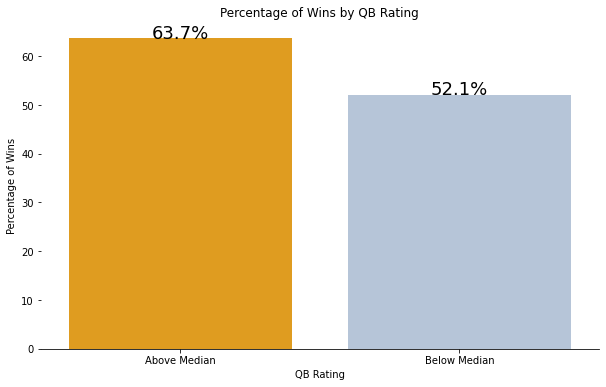

In [ ]:
med_df = merged_df

med_value = med_df['qb1_value_pre'].median()

med_df['compared_to_med'] = ['Above_med' if x > med_value else 'Below_med' for x in med_df['qb1_value_pre']]

counts = med_df.groupby(['compared_to_med', 'result1']).size().reset_index(name='Count')

total_games = counts.groupby('compared_to_med')['Count'].sum()

# calculate percentage of wins for each group
percent_wins = counts.pivot(index='compared_to_med', columns='result1', values='Count').apply(lambda x: x/x.sum(), axis=1)['Win'] *100

#figure size 
plt.figure(figsize=(10, 6))

#colors
colors= {"Above_med":"orange","Below_med":"lightsteelblue"}

# plot the results
ax = sns.barplot(x=percent_wins.index, y=percent_wins, palette=colors)

# add labels and formatting
ax.set_title('Percentage of Wins by QB Rating')
ax.set_xlabel('QB Rating')
ax.set_ylabel('Percentage of Wins')
ax.set_xticklabels(['Above Median', 'Below Median'], rotation=0)
sns.despine(left=True)

for i, value in enumerate(percent_wins.values):
    ax.text(i, value, f'{value:.1f}%', ha="center", fontsize=18)

plt.show()

Home teams with above median quarterbacks win 63.7 percent of games where teams with below median quarterbacks win 52.1 percent of games. When compared to the total home game win percentage of 57.9 percent, teams with better than median QB's perform slightly better. 

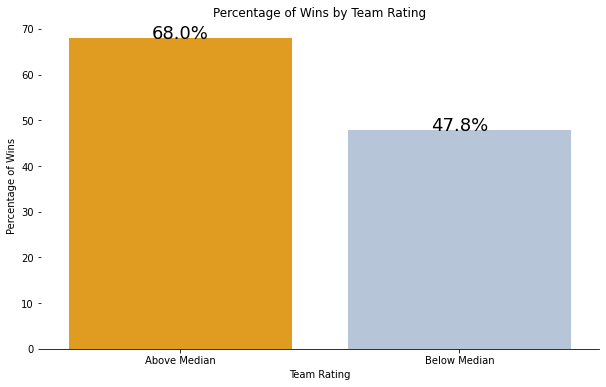

In [ ]:
med_value = med_df['elo1_pre'].median()

med_df['compared_to_med'] = ['Above_med' if x > med_value else 'Below_med' for x in med_df['elo1_pre']]

counts = med_df.groupby(['compared_to_med', 'result1']).size().reset_index(name='Count')

total_games = counts.groupby('compared_to_med')['Count'].sum()

# calculate percentage of wins for each group
percent_wins = counts.pivot(index='compared_to_med', columns='result1', values='Count').apply(lambda x: x/x.sum(), axis=1)['Win'] *100

#figure size 
plt.figure(figsize=(10, 6))

#colors
colors= {"Above_med":"orange","Below_med":"lightsteelblue"}

# plot the results
ax = sns.barplot(x=percent_wins.index, y=percent_wins, palette=colors)

# add labels and formatting
ax.set_title('Percentage of Wins by Team Rating')
ax.set_xlabel('Team Rating')
ax.set_ylabel('Percentage of Wins')
ax.set_xticklabels(['Above Median', 'Below Median'], rotation=0)
sns.despine(left=True)

for i, value in enumerate(percent_wins.values):
    ax.text(i, value, f'{value:.1f}%', ha="center", fontsize=18)

plt.show()

Home teams with an Elo above the median win 20.2 percent more games than home teams with a below median Elo. When compared to the QB rating, teams with above median Elos win more than teams with above median QB's.

## **Scatter / Line plot: Team vs QB**

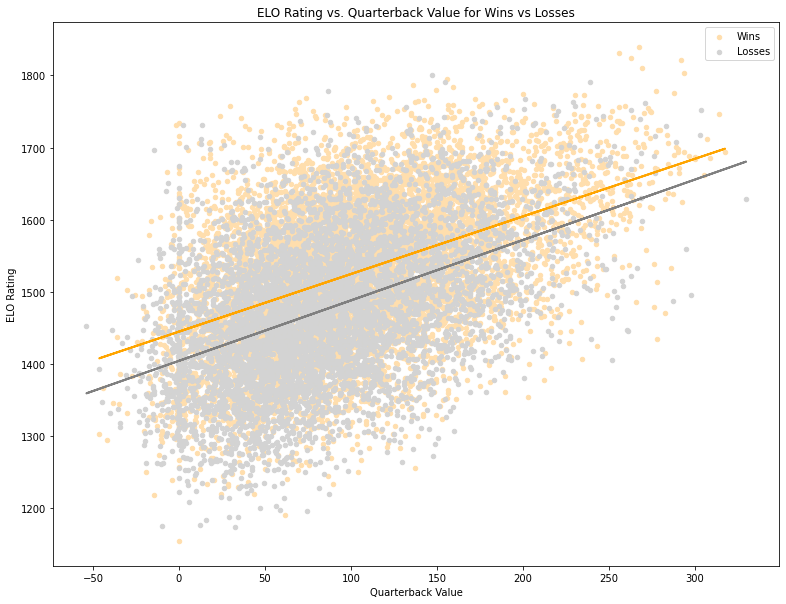

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

W = merged_df[merged_df['result1'].str.contains('Win')]
L = merged_df[merged_df['result1'].str.contains('Loss')]

fig, ax = plt.subplots(figsize=(13, 10))
W.plot.scatter(y='elo1_pre', x='qb1_value_pre', c='navajowhite',label='Wins', ax=ax)
L.plot.scatter(y='elo1_pre', x='qb1_value_pre',c='lightgrey',label='Losses', ax=ax)

x_R = np.array(W["qb1_value_pre"]).reshape(-1, 1)
y_R = np.array(W["elo1_pre"])

model_R = LinearRegression().fit(x_R, y_R)

x_D = np.array(L["qb1_value_pre"]).reshape(-1, 1)
y_D = np.array(L["elo1_pre"])

model_D = LinearRegression().fit(x_D, y_D)

ax.plot(x_R, model_R.predict(x_R), color='orange', linewidth=2, label='Line of Best Fit for Wins')
ax.plot(x_D, model_D.predict(x_D), color='grey', linewidth=2, label='Line of Best Fit for Losses')

# Set x and y axis labels
ax.set_xlabel('Quarterback Value')  # Set new x-axis label
ax.set_ylabel('ELO Rating')

# Set plot title
ax.set_title('ELO Rating vs. Quarterback Value for Wins vs Losses')

plt.show()

No matter how good the QB is, the overall team rating is higher at all values of the quarterback when a team wins. 

## **Linear model**

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Convert "Win" and "Loss" to 0 and 1
merged_df["wins1"] = merged_df["result1"].replace({"Win": 1, "Loss": 0})

# Define predictors and response
X = merged_df[["elo1_pre", "qb1_value_pre"]]
y = merged_df["wins1"]

# Fit logistic regression model
model = sm.Logit(y, sm.add_constant(X)).fit()

# Print statistical summary of the model
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.650977
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  wins1   No. Observations:                14648
Model:                          Logit   Df Residuals:                    14645
Method:                           MLE   Df Model:                            2
Date:                Tue, 07 Mar 2023   Pseudo R-squ.:                 0.04364
Time:                        23:38:33   Log-Likelihood:                -9535.5
converged:                       True   LL-Null:                       -9970.6
Covariance Type:            nonrobust   LLR p-value:                1.077e-189
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.7324      0.281    -23.941      0.000      -7.284      -6.181
elo1_pre          0.

Odds of a win with a 1 unit increase in team elo and everything else constant is ~3.8x higher than a 1 unit increase in quarterback elo.

## **Avg home elo vs wins**

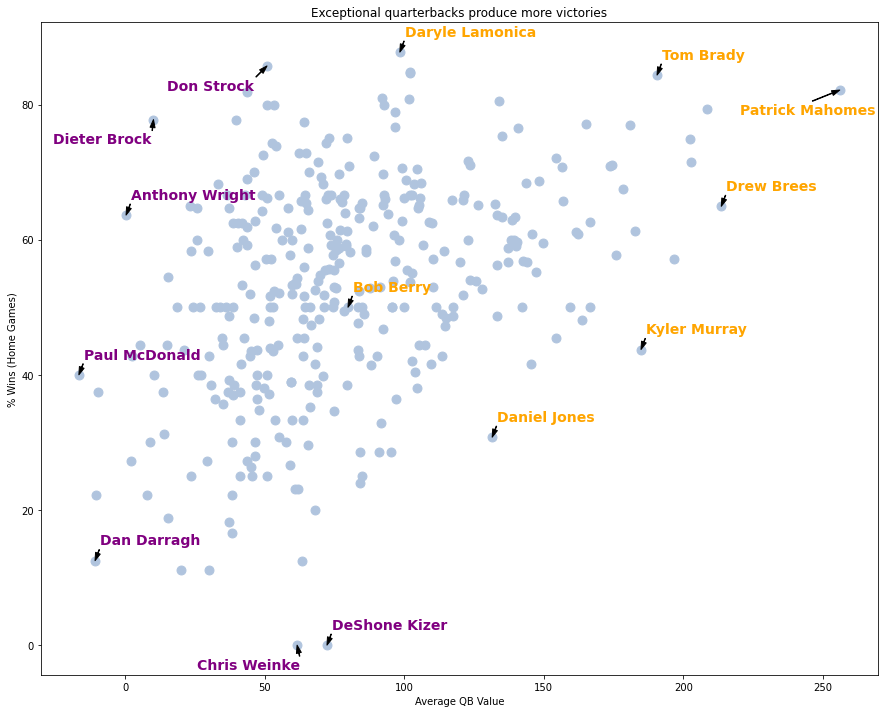

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

grouped = merged_df.groupby('qb1')['qb1_value_pre'].agg(['mean','median'])
grouped1 = merged_df.groupby('qb1')['result1'].agg(['count'])
grouped2 = merged_df.groupby('qb1')['result1'].agg(lambda x: (x == 'Win').sum())

merged = pd.merge(grouped2, grouped1, on='qb1')

merged['% Wins'] = (100*merged['result1'])/merged['count']

mergedqb = pd.merge(grouped, merged, on='qb1')

mergedqb1 = mergedqb[mergedqb['count'] >= 8]


fig, ax = plt.subplots(figsize=(15, 12))
mergedqb1.plot.scatter(y='% Wins', x='mean', c='lightsteelblue', ax=ax, s=80)

# Label individual points
label_points = {'Tom Brady': (190.566986, 84.357542),'Daryle Lamonica': (98.384553, 87.755102),
                'Drew Brees': (213.587293, 64.935065),'Kyler Murray': (184.820369, 43.750000), 'Daniel Jones': (131.479749, 30.769231),
                                            'Bob Berry': (79.807084, 50.000000)
}

for label, (x, y) in label_points.items():
    point = mergedqb1.loc[mergedqb1['mean'] == x]
    ax.annotate(label, (x, y), xytext=(5, 20), textcoords='offset points',
                ha='left', va='center', color='orange', fontsize=14,weight='bold',
                arrowprops=dict(facecolor='black', headwidth=5, headlength=8, width=.5))

label_points = {'DeShone Kizer': (72.272629,0),'Paul McDonald': (-16.644219,40),'Dan Darragh': (-10.849681, 12.500000), 
                'Anthony Wright': (0.266346, 63.636364)} 		

for label, (x, y) in label_points.items():
    point = mergedqb1.loc[mergedqb1['mean'] == x]
    ax.annotate(label, (x, y), xytext=(5, 20), textcoords='offset points',
                ha='left', va='center', color='purple', fontsize=14,weight='bold',
                arrowprops=dict(facecolor='black', headwidth=5, headlength=8, width=.5))

label_points = {'Chris Weinke': (61.557166,0 ),'Don Strock': (50.785878,85.714286), 'Dieter Brock':(10.094036,77.777778)}

for label, (x, y) in label_points.items():
    point = mergedqb1.loc[mergedqb1['mean'] == x]
    ax.annotate(label, (x, y), xytext=(-100,-20), textcoords='offset points',
                ha='left', va='center', color='purple', fontsize=14,weight='bold',
                arrowprops=dict(facecolor='black', headwidth=5, headlength=8, width=.5))


label_points = {'Patrick Mahomes': (256.060699, 82.142857)}

for label, (x, y) in label_points.items():
    point = mergedqb1.loc[mergedqb1['mean'] == x]
    ax.annotate(label, (x, y), xytext=(-100,-20), textcoords='offset points',
                ha='left', va='center', color='orange', fontsize=14,weight='bold',
                arrowprops=dict(facecolor='black', headwidth=5, headlength=8, width=.5))
    
# Set x and y axis labels
ax.set_ylabel('% Wins (Home Games)')  
# Set new x-axis label
ax.set_xlabel('Average QB Value')

# Set plot title
ax.set_title('Exceptional quarterbacks produce more victories')

plt.show()



The average QB value of all the quarterbacks shown on this graph is 79.51. For this analysis, we removed all qbs that had played less than 8 home games as this is a season's worth of games which should be enough values to better quantify a QBs average value in home games. Any points labeled that fall above that are labeled in orange and any points that fall below are be labeles in purple.

## **Results of Analysis** 



Given the results above, we belive that while quarterbacks are an important position, the team overall matters more for determining wins. This however doesn't discredit our hypothesis but makes it more inconclusive to say that quarterbacks are the single most important factor in teams wins. When a QB is exceptionally good a team wins more, however a team with a mediocre qb could still have high winning percentages. That being said, QBs success contibutes to the overall sucess of a team. 

## Notable quarterbacks outlined in plot



**Bob Berry** might be the most average quarterback ever (at home) with a QB value of 79.8 and a 50% win rate at home. Despite being a very average quarterback in terms of elo, Bob was selected for the Pro Bowl in 1969 and was a part of three superbowl teams with the vikings in the mid 1970's.

**Daryle Lamonica** has the highest win percentage at home of any quarterback who has played in at least 8 home games. He was nicknamed "the Mad Bomber" due to his affinity for throwing the long pass in virtually any situation. Lamonica led the Raiders to four consecutive division titles between 1967 and 1970 and had a superbowl appearance in Superbowl II with the Raiders. Lamonica was twice named AFL MVP, in addition to receiving three AFL All-Star selections, two NFL Pro Bowl selections, and two first-team All-AFL honors. 

**Tom Brady** has the seventh highest average QB value at home and the fifth highest win percentage at home. Despite what the QB value suggests, Tom Brady is widely regarded as the greatest quarterback ever. Brady led the Patriots to 17 division titles, 13 AFC Championship Games, nine Super Bowl appearances, and six Super Bowl titles, all of which are NFL records for a player and franchise.

**Patrick Mahomes** became an NFL starter in 2018 and since has averaged the highest QB value for home games. In his first season as starter, he was named to the Pro Bowl, named First Team All-Pro, and won the NFL Offensive Player of the Year and NFL Most Valuable Player awards. In the 2019 season, Mahomes led the Chiefs to Super Bowl LIV and Mahomes was awarded the Super Bowl MVP for his performance. Again in the 2022 season Mahomes won his second career NFL MVP and his second Super Bowl MVP.

**Drew Brees** has the second highest average QB value for home games yet a relatively low home game win percentage at only 65%. From 2006 to 2020, Brees led the Saints to nine playoff appearances, seven division titles, three NFC Championship Game appearances, and the franchise's first Super Bowl title in Super Bowl XLIV, earning him the game's MVP award. At his retirement Brees extended his total Pro Bowl selections to 13 and was twice named Offensive Player of the Year. He also led the NFL in passing yards a record seven times.

**Kyler Murray** has the eigth highest average QB value for home games but has a stunningly low win percentage of roughly 44%. In Murray's first season, he was named NFL Offensive Rookie of the Year after setting several Cardinals franchise rookie quarterback records. He received consecutive Pro Bowl selections during his next two seasons, along with leading the Cardinals to the playoffs in 2021.

**Daniel Jones** as of 3/7/2023, Jones signed a four year $160 million dollar contract, making him the seventh highest paid QB at the time of signing in the NFL. According to our data his winning percentage at home is only 31% through the 2021 season. His average home QB value is 131.5. 






In [ ]:
#mean qb value
mean_value = mergedqb1['mean'].mean()
mean_value

79.51478532795765

In [ ]:
sorted_df_desc = mergedqb1.sort_values(by='% Wins', ascending=False)

pd.set_option('display.max_rows', 5000)

sorted_df_desc


,mean,median,result1,count,% Wins
qb1,,,,,
Daryle Lamonica,98.384553,114.507134,43,49,87.755102
Don Strock,50.785878,55.768865,12,14,85.714286
Terry Bradshaw,101.945661,106.227675,78,92,84.782609
Otto Graham,101.989344,107.950735,33,39,84.615385
Tom Brady,190.566986,206.794374,151,179,84.357542
Patrick Mahomes,256.060699,261.737043,23,28,82.142857
Bob Waterfield,43.445742,42.224736,9,11,81.818182
Steve Bono,92.001046,93.808341,17,21,80.952381
John Elway,101.532401,98.740270,105,130,80.769231


*Dsiclosure: We would have liked to look into some more data but unfortunately much of NFL data is locked behind paywalls and many metrics are proprietary and impossible to calculate otherwise. It would have been interesting to look at other positions as well, but comparable data does not exist.*